In [ ]:
# !pip install -U statsmodels
# !pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.3 MB/s 


In [ ]:
import datetime as dt
import numpy as np
import pandas as pd

from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pandas.tseries.offsets import DateOffset


In [ ]:
transactions_df = pd.read_csv("/content/drive/MyDrive/transactions.csv")

In [ ]:
#remove not-so-usefull columns

drop_cols_list = [
                  "id",
                  "transaction_type_id",
                  "status_id",
                  "discount_id",
                  "amount_remaining",
                  "amount_received",
                #   "amount",
                  "payment_method_id",
                  "created_date",
                  "due_date",
                  "updated_date",
                  "transaction_type",
                  "transaction_status",
                  "source",
                  ]

# preprocessing
transactions_df = transactions_df[transactions_df["transaction_type"]=="SalesInvoice"].reset_index(drop=True).copy()
transactions_df.loc[:, "user_id"] = transactions_df["user_id"].astype(str).str.replace(".0", "", regex=False)
transactions_df.loc[:, "transaction_date"] = pd.to_datetime(transactions_df["transaction_date"])
transactions_df.loc[:, "due_date"] = pd.to_datetime(transactions_df["due_date"])
transactions_df = transactions_df.drop(drop_cols_list, axis=1)
#start day on each week based the latest date in transction
min_date_all_trx = transactions_df["transaction_date"].min()
max_date_all_trx = transactions_df["transaction_date"].max()
start_day = dt.timedelta(min_date_all_trx.weekday())
transactions_df["trx_weekly_date"] = transactions_df["transaction_date"].dt.to_period('W').apply(lambda r: r.start_time) + start_day

In [ ]:
transactions_df.head()

,transaction_date,user_id,discount_price,amount,trx_weekly_date
0,2020-06-14,23487084,7500.000000,6.000000e+04,2020-06-12
1,2020-01-10,17235256,0.000000,4.291071e+06,2020-01-10
2,2020-06-19,23487084,0.000000,3.214286e+04,2020-06-19
3,2020-06-29,23487084,0.000000,3.000000e+04,2020-07-03
4,2020-01-06,17235256,407812.500001,3.262500e+06,2020-01-10


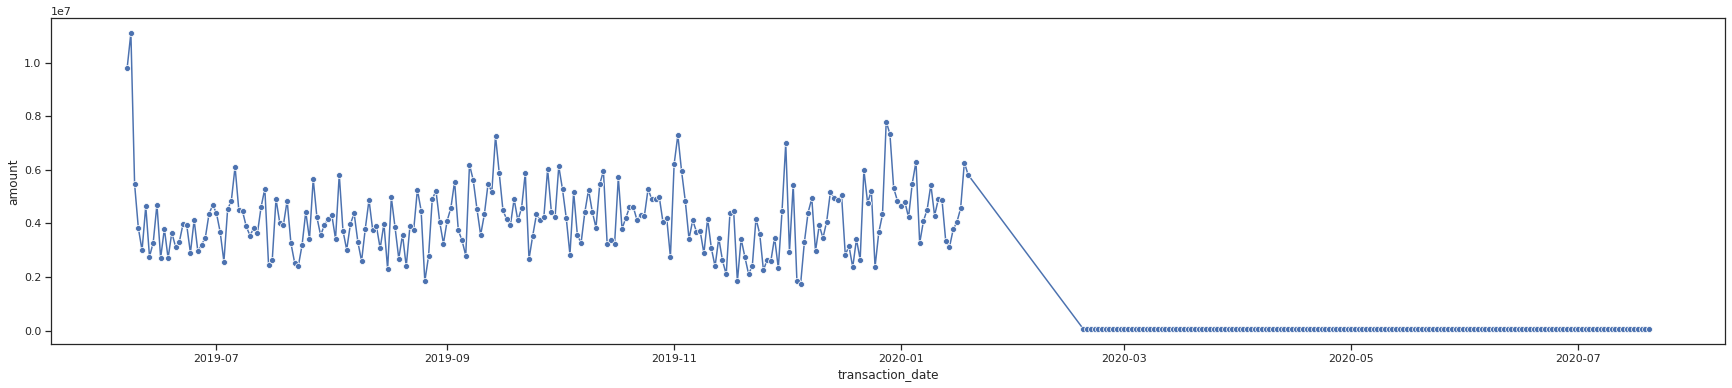

In [ ]:
# visualization transaction per day
fig, ax = plt.subplots(figsize=(30,6))
sns.lineplot(x="transaction_date", y="amount", marker="o", data=transactions_df, ax=ax)
plt.show()

In [ ]:
# convert to weekly tranasction
weekly_trx_df = transactions_df.groupby("trx_weekly_date").agg({"amount":sum}).reset_index()

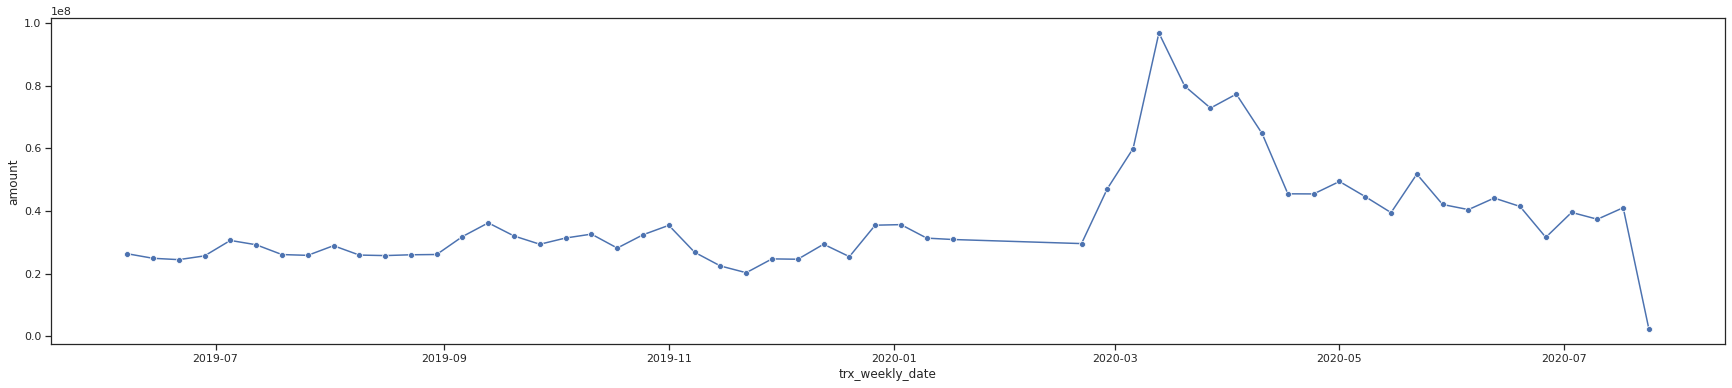

In [ ]:
# visualization transaction per week
fig, ax = plt.subplots(figsize=(30,6))
sns.lineplot(x="trx_weekly_date", y="amount", marker="o", data=weekly_trx_df, ax=ax)
plt.show()

In [ ]:
transposed =  weekly_trx_df.to_numpy().T[0]

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


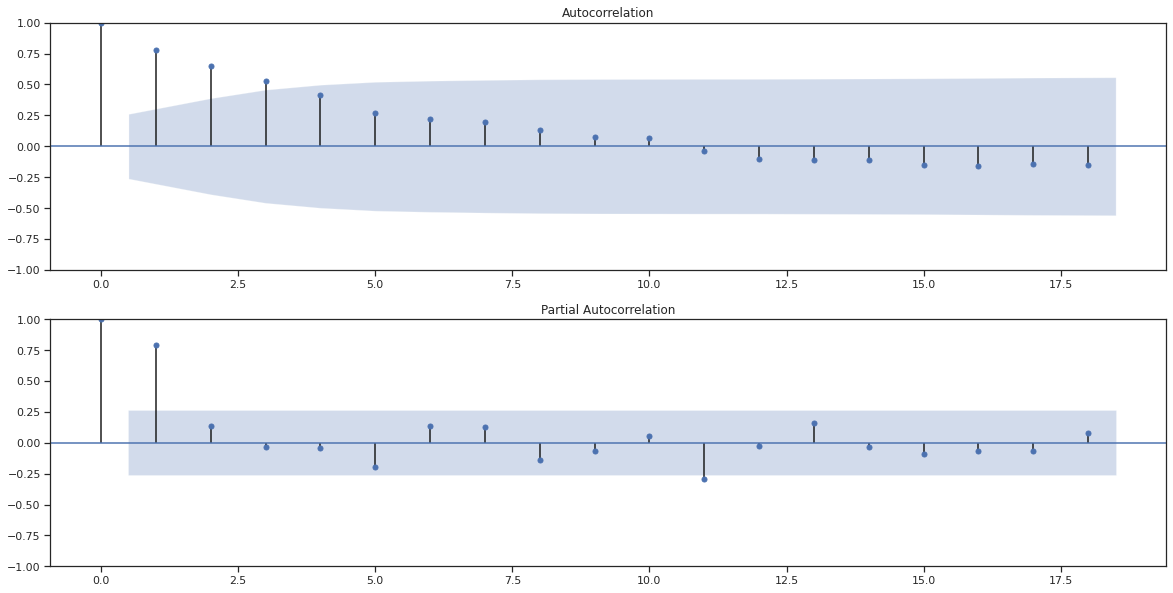

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))
plot_acf(weekly_trx_df.set_index("trx_weekly_date"), ax=ax[0])
plot_pacf(weekly_trx_df.set_index("trx_weekly_date"), ax=ax[1])
plt.show()

In [ ]:
def knn_mean(ts, n):
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            n_by_2 = np.ceil(n/2)
            lower = np.max([0, int(i-n_by_2)])
            upper = np.min([len(ts)+1, int(i+n_by_2)])
            ts_near = np.concatenate([ts[lower:i], ts[i:upper]])
            out[i] = np.nanmean(ts_near)
    return out
def seasonal_mean(ts, n, lr=0.7):
    """
    Compute the mean of corresponding seasonal periods
    ts: 1D array-like of the time series
    n: Seasonal window length of the time series
    """
    out = np.copy(ts)
    for i, val in enumerate(ts):
        if np.isnan(val):
            ts_seas = ts[i-1::-n]  # previous seasons only
            if np.isnan(np.nanmean(ts_seas)):
                ts_seas = np.concatenate([ts[i-1::-n], ts[i::n]])  # previous and forward
            out[i] = np.nanmean(ts_seas) * lr
    return out

In [ ]:
# establish time period by weekly
weekly_df = pd.DataFrame(pd.date_range(start= min_date_all_trx, end=max_date_all_trx, name="trx_weekly_date", freq="7D"))
joined_weekly_trx_df = weekly_df.join(weekly_trx_df.set_index("trx_weekly_date"), on="trx_weekly_date", how="left")

In [ ]:
joined_weekly_trx_df["value"] = seasonal_mean(joined_weekly_trx_df["amount"], n=12, lr=1.25)

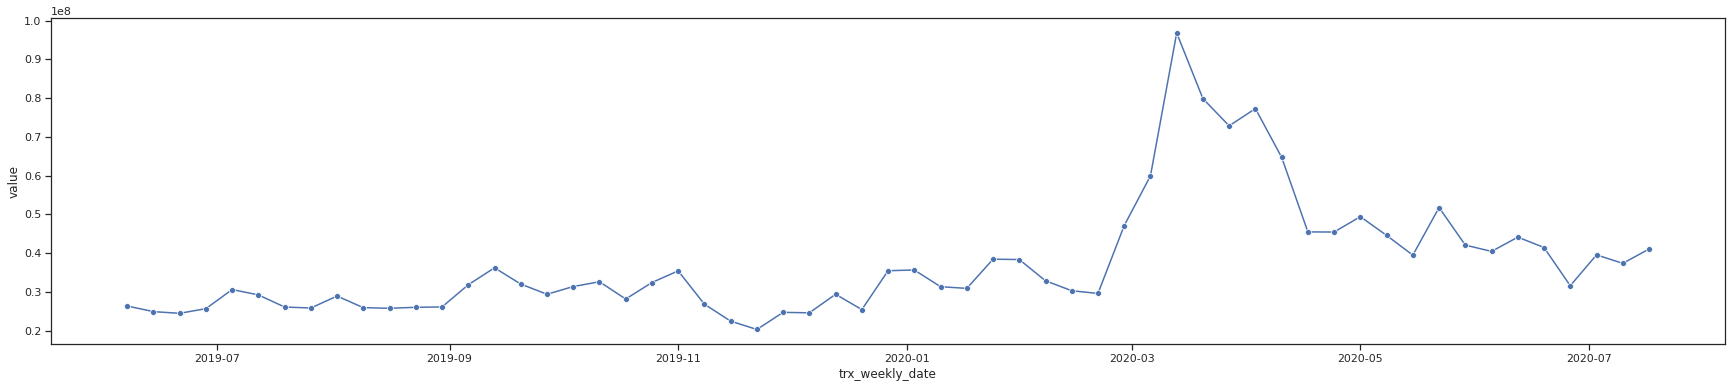

In [ ]:
# visualization transaction per week after filling missing value
fig, ax = plt.subplots(figsize=(30,6))
sns.lineplot(x="trx_weekly_date", y="value", marker="o", data=joined_weekly_trx_df, ax=ax)
plt.show()

In [ ]:
def SampEn(U, m, r):
    """Compute Sample entropy"""
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for j in range(len(x)) if i != j and _maxdist(x[i], x[j]) <= r]) for i in range(len(x))]
        return sum(C)

    N = len(U)
    return -np.log(_phi(m+1) / _phi(m))


In [ ]:
# check forcastibility
SampEn(joined_weekly_trx_df["value"], m=2, r=0.2*np.std(joined_weekly_trx_df["value"]))

#doc: https://en.wikipedia.org/wiki/Sample_entropy#:~:text=Generally%20we%20take,very%20large%20population.
#0.938 -> quite complex and hard to predict

0.9382696385929302

In [ ]:
#check stationary
result = adfuller(joined_weekly_trx_df["value"])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.123699303052593
p-value: 0.2350923800907576
Critial Values:
   1%, -3.548493559596539
Critial Values:
   5%, -2.912836594776334
Critial Values:
   10%, -2.594129155766944


In [ ]:
#differencing for ARIMA model since p value > 0.5

# joined_weekly_trx_df["diff_shift"] = joined_weekly_trx_df["value"]-joined_weekly_trx_df["value"].shift(1)

# 1 time differencing to get well-stationary even though is not p-value < 0.5
# if more than 1 time, then higher possibility over-differenced
joined_weekly_trx_df["value_diff"] = joined_weekly_trx_df["value"].diff()

In [ ]:
#check stationary
result = adfuller(joined_weekly_trx_df["value_diff"].dropna())
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -7.323317688926434
p-value: 1.1785643976925105e-10
Critial Values:
   1%, -3.5506699942762414
Critial Values:
   5%, -2.913766394626147
Critial Values:
   10%, -2.5946240473991997


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


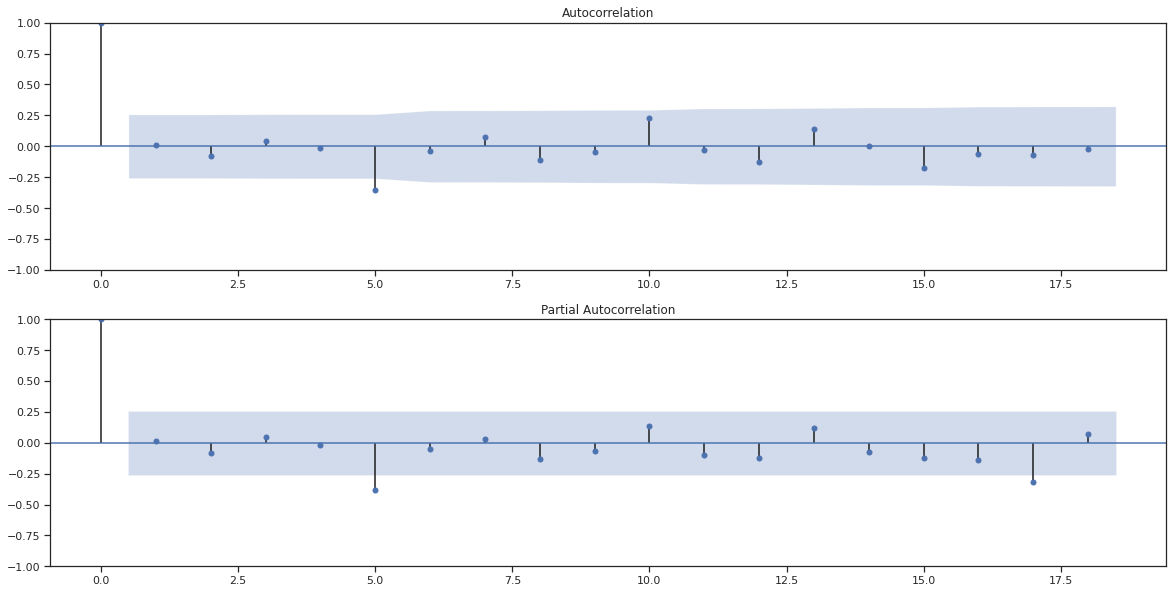

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20,10))
plot_acf(joined_weekly_trx_df.set_index("trx_weekly_date")["value_diff"].dropna(), ax=ax[0])
plot_pacf(joined_weekly_trx_df.set_index("trx_weekly_date")["value_diff"].dropna(), ax=ax[1])
plt.show()

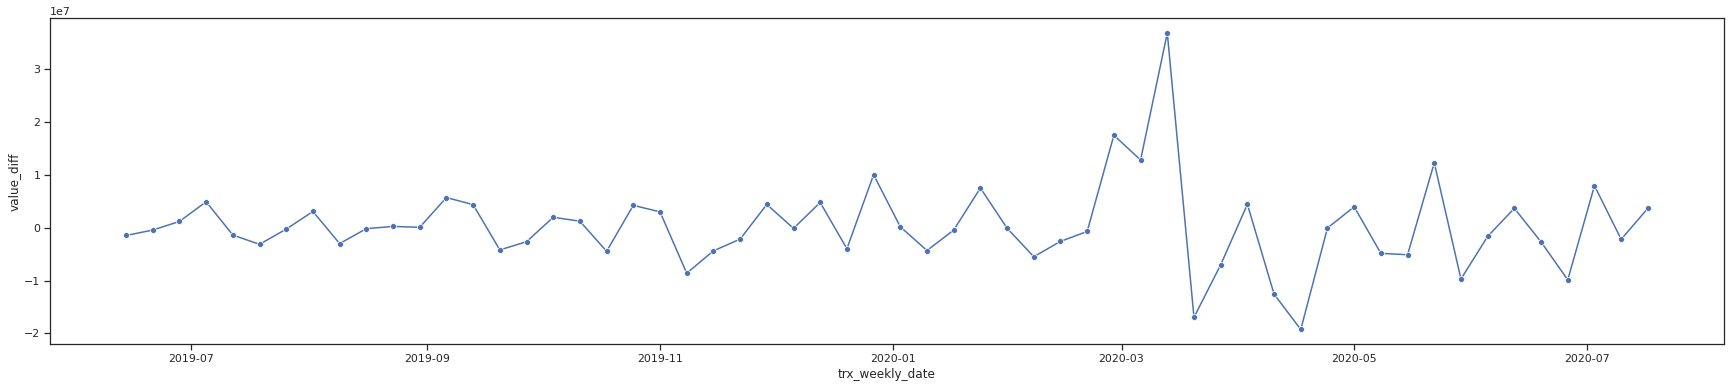

In [ ]:
# visualization transaction per week after 1 time differencing
fig, ax = plt.subplots(figsize=(30,6))
sns.lineplot(x="trx_weekly_date", y="value_diff", marker="o", data=joined_weekly_trx_df[["trx_weekly_date", "value_diff",]].dropna(), ax=ax)
plt.show()

In [ ]:
from pmdarima.arima.utils import ndiffs
## Adf Test
y_ =joined_weekly_trx_df[["trx_weekly_date", "value_diff",]].set_index("trx_weekly_date").dropna()
print(ndiffs(y_, test='adf') ) # 2

# KPSS test
print(ndiffs(y_, test='kpss') ) # 0

# PP test:
print(ndiffs(y_, test='pp'))  # 2

0
0
0


In [ ]:
train = joined_weekly_trx_df[["trx_weekly_date", "value",]].set_index("trx_weekly_date").dropna()
# 1,1,2 ARIMA Model
# doc: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
# doc: https://people.duke.edu/~rnau/arimrule.htm
# 56 is total week in a year
model = SARIMAX(train["value"], order=(1,1,2), seasonal_order=(1, 0, 0, 56))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               value   No. Observations:                   59
Model:             SARIMAX(1, 1, 2)x(1, 0, [], 56)   Log Likelihood               -1003.965
Date:                             Sun, 20 Feb 2022   AIC                           2017.930
Time:                                     13:28:08   BIC                           2028.232
Sample:                                 06-07-2019   HQIC                          2021.942
                                      - 07-17-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7997      0.318      2.512      0.012       0.176       1.424
ma.L1         -0.8308      

In [ ]:
new_dates=[train.index[-1]+DateOffset(weeks=x) for x in range(1,78)]
df_pred=pd.DataFrame(index=new_dates,columns =train.columns)

In [ ]:
df_result =pd.concat([train,df_pred])
df_result["prediction"]=model_fit.predict(start=0,end=138)

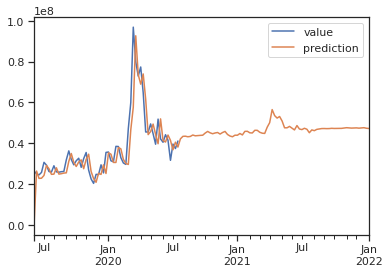

In [ ]:
df_result[["value","prediction"]].plot()

In [ ]:
df_result_melted = df_result[["value","prediction"]].reset_index()
df_result_melted = df_result_melted.melt(id_vars=["index"], var_name="type", value_name="amount")

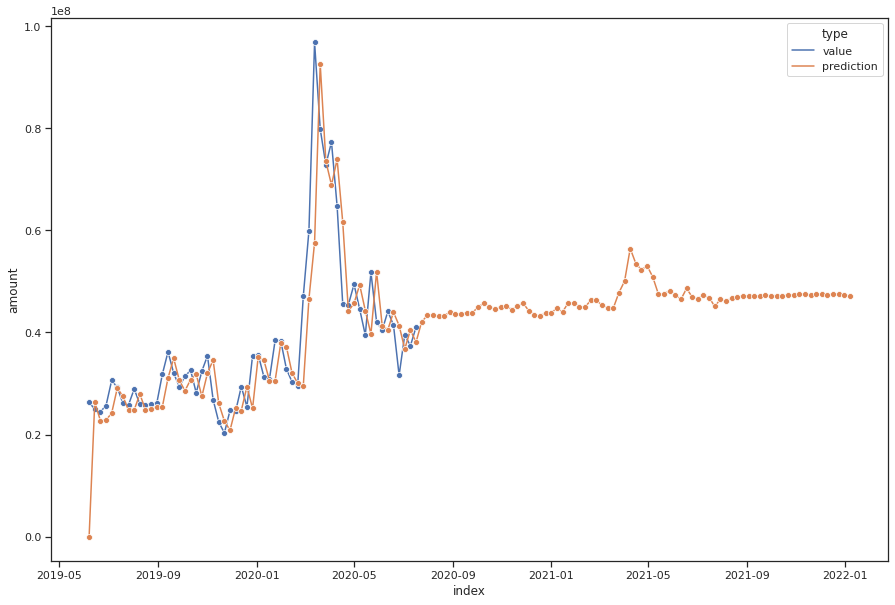

In [ ]:
# visualization result
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(x="index", y="amount", hue="type", marker="o", data=df_result_melted, ax=ax)
plt.show()

In [ ]:
train.shape

(59, 1)

In [ ]:
df_result_melted

,index,type,amount
0,2019-06-07,value,2.636357e+07
1,2019-06-14,value,2.490429e+07
2,2019-06-21,value,2.447250e+07
3,2019-06-28,value,2.567357e+07
4,2019-07-05,value,3.060321e+07
...,...,...,...
267,2021-12-10,prediction,4.734939e+07
268,2021-12-17,prediction,4.747958e+07
269,2021-12-24,prediction,4.757215e+07
270,2021-12-31,prediction,4.731367e+07


In [ ]:
df_result[["prediction"]].reset_index().to_csv("prediction.csv")